In [1]:
using Revise, OrdinaryDiffEq, Flux, DiffEqFlux, Optim
using Plots, FileIO, JLD2, OffsetArrays, ProgressMeter, Kinetic

┌ Error: (compiled mode) evaluation error starting at /home/vavrines/.julia/packages/DistributionsAD/BtYLj/src/reversediff.jl:19
│   mod = DistributionsAD.ReverseDiffX
│   ex = begin
    #= /home/vavrines/.julia/packages/DistributionsAD/BtYLj/src/reversediff.jl:19 =#
    const RDBroadcasted{F, T} = Broadcasted{<:Any, <:Any, F, T}
end
│   exception = (ErrorException("invalid redefinition of constant RDBroadcasted"), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007efc246f372f, Ptr{Nothing} @0x00007efc2478094c, Ptr{Nothing} @0x00007efc247830f8, Ptr{Nothing} @0x00007efc24783fe7, Base.InterpreterIP in top-level CodeInfo for DistributionsAD.ReverseDiffX at statement 15])
└ @ Revise /home/vavrines/.julia/packages/Revise/BqeJF/src/lowered.jl:85


In [25]:
case = "shock"
space = "1d2f1v"
nSpecies = 1
interpOrder = 1
limiter = "vanleer"
cfl = 0.7
maxTime = 250.0
x0 = -25.0
x1 = 25.0
nx = 50
pMeshType = "uniform"
nxg = 1
umin = -10.0
umax = 10.0
nu = 48
nug = 0
vmin = -10.0
vmax = 10.0
nv = 28
nvg = 0
wmin = -10.0
wmax = 10.0
nw = 28
nwg = 0
vMeshType = "rectangle"
knudsen = 1.0
mach = 2.0
prandtl = 0.6666667
inK = 2
omega = 0.5
alphaRef = 1.0
omegaRef = 0.5
nm = 5
tLen = 3
nh = 12

12

In [26]:
γ = heat_capacity_ratio(inK, 1)
set = Setup(case, space, nSpecies, interpOrder, limiter, cfl, maxTime)
pSpace = PSpace1D(x0, x1, nx, pMeshType, nxg)
μᵣ = ref_vhs_vis(knudsen, alphaRef, omegaRef)
gas = GasProperty(knudsen, mach, prandtl, inK, γ, omega, alphaRef, omegaRef, μᵣ)
vSpace = VSpace1D(umin, umax, nu, vMeshType)
vSpace2D = VSpace2D(vmin, vmax, nv, wmin, wmax, nw, vMeshType)
vSpace3D = VSpace3D(umin, umax, nu, vmin, vmax, nv, wmin, wmax, nw, vMeshType)
wL, primL, hL, bL, bcL, wR, primR, hR, bR, bcR = ib_rh(mach, γ, vSpace.u, inK)
ib = IB2F(wL, primL, hL, bL, bcL, wR, primR, hR, bR, bcR)
ks = SolverSet(set, pSpace, vSpace, gas, ib, pwd())

kn_bzm = hs_boltz_kn(ks.gas.μᵣ, 1.0)
sos = sound_speed(ks.ib.primR, γ)
tmax = (ks.vSpace.u1 + sos) / ks.pSpace.dx[1]
dt = Float32(ks.set.cfl / tmax)
tspan = (0.f0, dt)
tran = range(tspan[1], tspan[2], length = tLen)

0.0f0:0.030929746f0:0.061859492f0

In [34]:
ctr = OffsetArray{ControlVolume1D2F}(undef, eachindex(ks.pSpace.x))
face = Array{Interface1D2F}(undef, ks.pSpace.nx + 1)
for i in eachindex(ctr)
    if i <= ks.pSpace.nx ÷ 2
        ctr[i] = ControlVolume1D2F(
            ks.pSpace.x[i],
            ks.pSpace.dx[i],
            Float32.(ks.ib.wL),
            Float32.(ks.ib.primL),
            Float32.(ks.ib.hL),
            Float32.(ks.ib.bL),
        )
    else
        ctr[i] = ControlVolume1D2F(
            ks.pSpace.x[i],
            ks.pSpace.dx[i],
            Float32.(ks.ib.wR),
            Float32.(ks.ib.primR),
            Float32.(ks.ib.hR),
            Float32.(ks.ib.bR),
        )
    end
end
for i = 1:ks.pSpace.nx+1
    face[i] = Interface1D2F(ks.ib.wL, ks.ib.hL)
end

In [28]:
phi, psi, phipsi = kernel_mode(
    nm,
    vSpace3D.u1,
    vSpace3D.v1,
    vSpace3D.w1,
    vSpace3D.du[1, 1, 1],
    vSpace3D.dv[1, 1, 1],
    vSpace3D.dw[1, 1, 1],
    vSpace3D.nu,
    vSpace3D.nv,
    vSpace3D.nw,
    alphaRef,
)

function boltzmann(f, p, t)
    Kn, M, phi, psi, phipsi = p
    return boltzmann_fft(f[1:end,1:end,1:end], Kn, M, phi, psi, phipsi)
end

function boltzmann!(df, f, p, t)
    Kn, M, phi, psi, phipsi = p
    df .= boltzmann_fft(f, Kn, M, phi, psi, phipsi)
end

boltzmann! (generic function with 1 method)

In [29]:
function step_be!(
    fwL,
    fhL,
    fbL,
    w,
    prim,
    h,
    b,
    fwR,
    fhR,
    fbR,
    K,
    γ,
    μ,
    ω,
    u,
    weights,
    dx,
    tran,
)

    #--- record W^{n} ---#
    w_old = deepcopy(w)
    H = maxwellian(u, prim)
    B = H .* K ./ (2.0 .* prim[end])
    τ = vhs_collision_time(prim, μ, ω)

    f_star =
        full_distribution(h, b, u, weights, vSpace3D.v, vSpace3D.w, prim, γ)
    df = boltzmann(f_star, [kn_bzm, nm, phi, psi, phipsi], tspan)
    
    #df = (maxwellian(vSpace3D.u, vSpace3D.v, vSpace3D.w, [prim[1],prim[2],0.,0.,prim[3]]) .- f_star) ./ τ
    
    f_star .+= df .* dt

    #prob = ODEProblem(boltzmann!, f_full, tspan, [kn_bzm, nm, phi, psi, phipsi])
    #f_star = Array(solve(prob, Midpoint(), u0=f_full, saveat = tran))[:, :, :, end]

    hstar, bstar =
        reduce_distribution(f_star, vSpace3D.v, vSpace3D.w, vSpace2D.weights)

    for i in eachindex(h)
        h[i] = hstar[i] + (fhL[i] - fhR[i]) / dx
        b[i] = bstar[i] + (fbL[i] - fbR[i]) / dx
        #h[i] = h[i] + (fhL[i] - fhR[i]) / dx
        #b[i] = b[i] + (fbL[i] - fbR[i]) / dx
    end

    #--- update W^{n+1} ---#
    @. w += (fwL - fwR) / dx
    prim .= conserve_prim(w, γ)

end

step_be! (generic function with 1 method)

In [35]:
function solve!(ks, ctr, face, dt, res, X)
    @showprogress for iter = 1:2000
        Kinetic.evolve!(ks, ctr, face, dt)
        Kinetic.update!(ks, ctr, face, dt, res)

        if iter % 10 == 0 && iter < 200
           X = hcat(X, [ctr[24].h;ctr[24].b], [ctr[25].h;ctr[25].b], [ctr[26].h;ctr[26].b], [ctr[27].h;ctr[27].b]) 
        end
    end
    
    return X
end

solve! (generic function with 1 method)

In [36]:
X = Array{Float32}(undef, nu * 2, ks.pSpace.nx)
for i = 1:ks.pSpace.nx
    X[1:nu, i] .= ctr[i].h
    X[nu+1:end, i] .= ctr[i].b
end

res = Array{Float32}(undef, 3)

X = solve!(ks, ctr, face, dt, res, X);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [127]:
# loop of neural Boltzmann equation
@showprogress for iter = 1:50
    Kinetic.evolve!(ks, ctr, face, dt)

    for i = 2:49
        step_be!(
            face[i].fw,
            face[i].fh,
            face[i].fb,
            ctr[i].w,
            ctr[i].prim,
            ctr[i].h,
            ctr[i].b,
            face[i+1].fw,
            face[i+1].fh,
            face[i+1].fb,
            ks.gas.K,
            ks.gas.γ,
            ks.gas.μᵣ,
            ks.gas.ω,
            ks.vSpace.u,
            ks.vSpace.weights,
            ctr[i].dx,
            tran,
        )
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


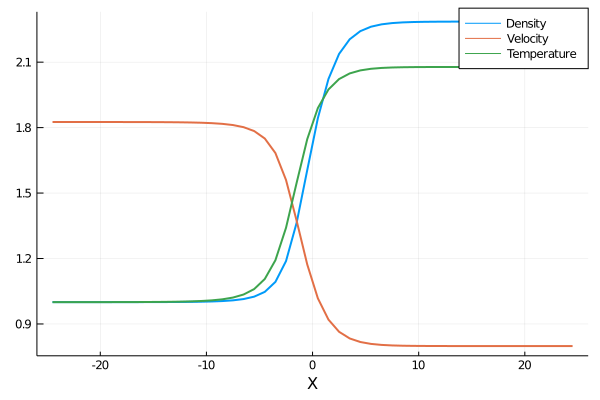

In [23]:
plot_line(ks, ctr)

In [129]:
@save "sol1d.jld2" ks ctr

In [37]:
@save "X1d.jld2" X